In [1]:
import pandas as pd
import pickle
import numpy as np
import re 

# read xlxs
df1 = pd.read_excel('DATASET.VER4.xlsx', sheet_name='POS Data')
df2 = pd.read_excel('DATASET.VER4.xlsx', sheet_name='Loyalty2')
df3 = pd.read_excel('DATASET.VER4.xlsx', sheet_name='Hierachy Categories & Barcodes')

# save to pickle
df1.to_pickle("posdata.pkl")
df2.to_pickle("loyalty.pkl")
df3.to_pickle("categories.pkl")

#read the pickle file
picklefile1 = open('posdata.pkl', 'rb')
picklefile2 = open('loyalty.pkl', 'rb')
picklefile3 = open('categories.pkl', 'rb')
#unpickle the dataframe
df_posdata = pickle.load(picklefile1)
df_loyalty = pickle.load(picklefile2)
df_categories = pickle.load(picklefile3)
#close file
picklefile1.close()
picklefile2.close()
picklefile3.close()


pd.set_option('display.max_rows', 65)

In [2]:
df_start = df_categories.groupby(["Category Final"]).count().sort_values("Barcode", ascending = False)
df_pc = pd.merge(df_posdata, df_categories, on='Barcode', how='inner')

#νέο df με προϊόντα ανά καλάθι
df_baskets = df_pc.groupby(["Basket_ID"]).sum("Quantity").sort_values("Quantity", ascending = False)
df_loyalty.rename(columns = {'Cardholder':'LoyaltyCard_ID'}, inplace = True)
df_all = pd.merge(df_posdata, df_loyalty, on='LoyaltyCard_ID', how='inner')
all_data = df_all = pd.merge(df_all, df_categories, on='Barcode', how='inner')
df_sumquantitybasket = df_posdata.groupby(["Basket_ID"]).sum("Quantity")

# https://stackoverflow.com/questions/43348194/pandas-select-rows-if-id-appear-several-time
dca = all_data[all_data['Basket_ID'].duplicated(keep=False)]

# Referenced: https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
dca['Grouped'] = dca.groupby('Basket_ID')['Category Final'].transform(lambda x: ','.join(x))
dcb = dca[['Basket_ID', 'Grouped']].drop_duplicates()


df_a = pd.merge(dcb,df_sumquantitybasket, on='Basket_ID', how='inner')
sum = df_sumquantitybasket.drop(['Barcode','LoyaltyCard_ID'], axis=1)
a = pd.merge(dcb, all_data, on='Basket_ID', how='inner')
a = a.groupby(['Basket_ID']).sum('Quantity')


# https://stackoverflow.com/questions/43348194/pandas-select-rows-if-id-appear-several-time
dff = all_data[all_data['Basket_ID'].duplicated(keep=False)]

# Referenced: https://stackoverflow.com/questions/27298178/concatenate-strings-from-several-rows-using-pandas-groupby
dff['Grouped'] = dff.groupby('Basket_ID')['Category Final'].transform(lambda x: ','.join(x))
d2 = dff[['Basket_ID', 'Grouped','Status','Date']].drop_duplicates()

In [3]:
from datetime import datetime
da = pd.merge(d2,df_sumquantitybasket, on='Basket_ID', how='inner')
da['date'] = pd.to_datetime(da['Date'])
dw_mapping={
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 
da['day_of_week_name']=da['date'].dt.weekday.map(dw_mapping)
da = da.drop(columns=['date'])

In [ ]:
(da.loc[(da['Value'] < 0.45) & (da['Quantity'] > 4)]) #αυτές οι εγγραφές πρέπει να σβηστούν 

In [4]:

### Data Standardization and Modeling with K-Means and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

x = df_sumquantitybasket.copy()
y = df_start.copy()
iny = y.index.values
inx = x.index.values
inn = pd.DataFrame(0, index=inx, columns=iny)
ad = all_data.copy()
ad = ad.drop(columns = ['Date','Barcode','Quantity','Value','LoyaltyCard_ID','Status','Category A','Category B','Category C'])


In [5]:
#ΑΡΧΙΚΟΠΟΙΗΣΗ ΠΙΝΑΚΑ
for i in range (len(ad)):
    inn.at[str(ad.loc[i, "Basket_ID"]),str(ad.loc[i, "Category Final"])] = 1

In [6]:
inn

,ΞΗΡΟΙ ΚΑΡΠΟΙ/ΣΝΑΚΣ,ΤΥΡΟΚΟΜΙΚΑ,ΠΕΡΙΠΟΙΗΣΗ ΣΩΜΑΤΟΣ,ΚΑΘΑΡΙΣΤΙΚΑ,ΑΠΟΡΡΥΠΑΝΤΙΚΑ,ΚΡΑΣΙΑ/ΜΠΥΡΕΣ,ΠΕΡΙΠΟΙΗΣΗ ΜΑΛΛΙΩΝ,ΜΠΙΣΚΟΤΑ,ΚΡΕΑΤΙΚΑ/ΨΑΡΙΚΑ,ΑΝΑΨΥΚΤΙΚΑ,...,ΣΟΥΠΕΣ,ΕΠΟΧΙΑΚΑ ΕΙΔΗ,ΕΘΝΙΚΣ,ΠΟΥΡΕΣ,ΒΑΜΒΑΚΙΑ,ΗΛΕΚΤΡΙΚΕΣ ΣΥΣΚΕΥΕΣ,ΒΙΒΛΙΟΧΑΡΤΟΠΩΛΕΙΟ,ΔΙΑΦΟΡΑ (ΜΗ ΤΡΟΦΙΜΑ),ΠΡΟΙΟΝΤΑ ΓΛΥΚΟΠΩΛΕΙΟΥ,ΠΑΙΧΝΙΔΙ ΑΘΛΗΤΙΣΜΟΣ
C117311B124D20181119,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
C117311B140D20181027,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C117311B157D20181102,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C117311B77D20181122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C122293B128D20190228,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C29501639B166D20190613,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
C29501639B44D20190625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C29501646B249D20190527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C29522019B193D20190729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

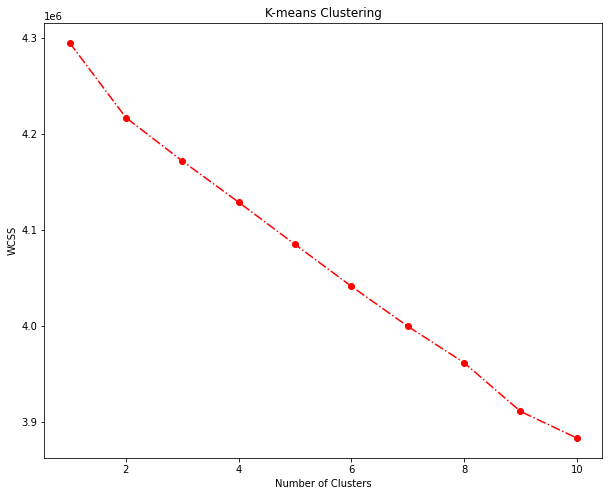

In [7]:
import matplotlib.pyplot as plt
scaler = StandardScaler()
df_std = scaler.fit_transform(inn)
df_std = pd.DataFrame(data = df_std,columns = inn.columns)
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(df_std)
    wcss.append(kmeans_pca.inertia_)
    plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()   #ΕΔΩ ΔΕΙΧΝΕΙ ΤΟΝ ΙΔΑΝΙΚΟ ΑΡΙΘΜΟ Κ ΓΙΑ CLUSTERING 

In [9]:
#CLUSTERING WITH NUMBER = 7  !keep

kmeans = KMeans(n_clusters = 7, random_state = 0 )
y_pred = kmeans.fit_predict(inn)
#create 2 new dataframes
categories_df0 = inn.copy()
categories_df0['clusters'] = y_pred
categ_totals0 = categories_df0.groupby(by='clusters')
totals0 = categ_totals0.sum()
totals0 = totals0.div(categ_totals0.size(),axis=0)
cluster0 = totals0.iloc[0].nlargest(20).to_frame('participation').reset_index()
cluster1 = totals0.iloc[1].nlargest(20).to_frame('participation').reset_index()
cluster2 = totals0.iloc[2].nlargest(20).to_frame('participation').reset_index()
cluster3 = totals0.iloc[3].nlargest(20).to_frame('participation').reset_index()
cluster4 = totals0.iloc[4].nlargest(20).to_frame('participation').reset_index()
cluster5 = totals0.iloc[5].nlargest(20).to_frame('participation').reset_index()
cluster6 = totals0.iloc[6].nlargest(20).to_frame('participation').reset_index()

cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6

(                 index  participation
 0           ΤΥΡΟΚΟΜΙΚΑ       0.954053
 1            ΑΛΛΑΝΤΙΚΑ       0.850028
 2                 ΨΩΜΙ       0.774674
 3               ΓΑΛΑΤΑ       0.670281
 4            ΓΙΑΟΥΡΤΙΑ       0.199963
 5             ΜΠΙΣΚΟΤΑ       0.176622
 6            ΣΟΚΟΛΑΤΕΣ       0.145929
 7   ΞΗΡΟΙ ΚΑΡΠΟΙ/ΣΝΑΚΣ       0.137659
 8      ΠΡΟΙΟΝΤΑ ΧΑΡΤΟΥ       0.137107
 9      ΚΡΕΑΤΙΚΑ/ΨΑΡΙΚΑ       0.110641
 10               ΚΑΦΕΣ       0.110274
 11                COLA       0.106414
 12               ΧΥΜΟΙ       0.105128
 13          ΔΗΜΗΤΡΙΑΚΑ       0.102738
 14             ΒΟΥΤΥΡΑ       0.100533
 15            ΚΡΟΥΑΣΑΝ       0.099798
 16       ΑΠΟΡΡΥΠΑΝΤΙΚΑ       0.098695
 17            ΖΥΜΑΡΙΚΑ       0.092998
 18          ΑΝΑΨΥΚΤΙΚΑ       0.081235
 19       ΚΡΑΣΙΑ/ΜΠΥΡΕΣ       0.080500,
                  index  participation
 0                ΚΑΦΕΣ       1.000000
 1           ΤΥΡΟΚΟΜΙΚΑ       0.369618
 2               ΓΑΛΑΤΑ       0.293662
 3      ΠΡΟΙΟΝΤΑ ΧΑΡΤΟΥ 

In [10]:
bb = categories_df0.loc[categories_df0['clusters'] == 0]
bb = bb.reset_index()
baskets0 = bb[['index','clusters']]
ddd = df_sumquantitybasket.copy()
baskets0.rename(columns = {'index':'Basket_ID'}, inplace = True)
ddd = ddd.reset_index()
baskets0 = pd.merge(baskets0, ddd, on='Basket_ID', how='inner')
baskets0 = baskets0.drop(['Barcode','LoyaltyCard_ID'], axis=1)
   #5441/45212 = 12.03% ΣΑΝΤΟΥΙΤΣ

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [11]:
baskets0

,Basket_ID,clusters,Quantity,Value
0,C28002183B165D20181011,0,9,25.80
1,C28002183B40D20181004,0,4,8.67
2,C28002183B497D20190321,0,9,19.45
3,C28002183B85D20190610,0,8,16.03
4,C28002183B86D20190131,0,6,18.59
...,...,...,...,...
5436,C29438682B226D20190511,0,11,21.38
5437,C29438682B31D20190603,0,8,15.04
5438,C29464676B620D20190319,0,4,6.84
5439,C29464676B626D20190410,0,3,8.72


In [12]:
bb = categories_df0.loc[categories_df0['clusters'] == 1]
bb = bb.reset_index()
baskets1 = bb[['index','clusters']]
ddd = df_sumquantitybasket.copy()
baskets1.rename(columns = {'index':'Basket_ID'}, inplace = True)
ddd = ddd.reset_index()
baskets1 = pd.merge(baskets1, ddd, on='Basket_ID', how='inner')
baskets1 = baskets1.drop(['Barcode','LoyaltyCard_ID'], axis=1)   #4134/45212 = 9.14% ΠΡΩΙΝΟ

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [13]:
baskets1

,Basket_ID,clusters,Quantity,Value
0,C117311B140D20181027,1,8,23.17
1,C28002183B117D20190606,1,4,27.09
2,C28030067B211D20190304,1,3,8.37
3,C28030119B410D20181207,1,12,19.36
4,C28031107B205D20190320,1,6,21.49
...,...,...,...,...
4129,C29359169B327D20190819,1,4,8.53
4130,C29359169B52D20190727,1,4,9.33
4131,C29359169B53D20190725,1,12,19.67
4132,C29359169B801D20190411,1,4,7.71


In [14]:
bb = categories_df0.loc[categories_df0['clusters'] == 2]
bb = bb.reset_index()
baskets2 = bb[['index','clusters']]
ddd = df_sumquantitybasket.copy()
baskets2.rename(columns = {'index':'Basket_ID'}, inplace = True)
ddd = ddd.reset_index()
baskets2 = pd.merge(baskets2, ddd, on='Basket_ID', how='inner')
baskets2 = baskets2.drop(['Barcode','LoyaltyCard_ID'], axis=1)
  #8032/45212 = 17.77% ΓΑΛΑΚΤΟΚΟΜΙΚΑ

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [15]:
baskets2

,Basket_ID,clusters,Quantity,Value
0,C122293B231D20190216,2,10,19.51
1,C28002183B105D20190225,2,3,5.99
2,C28002183B106D20190105,2,2,1.95
3,C28002183B108D20190520,2,2,6.92
4,C28002183B14D20190218,2,3,8.51
...,...,...,...,...
8027,C29446265B16D20190702,2,2,1.88
8028,C29446265B194D20190821,2,3,4.82
8029,C29446265B343D20190605,2,3,2.92
8030,C29464747B493D20190727,2,5,7.61


In [16]:
bb = categories_df0.loc[categories_df0['clusters'] == 3]
bb = bb.reset_index()
baskets3 = bb[['index','clusters']]
ddd = df_sumquantitybasket.copy()
baskets3.rename(columns = {'index':'Basket_ID'}, inplace = True)
ddd = ddd.reset_index()
baskets3 = pd.merge(baskets3, ddd, on='Basket_ID', how='inner')
baskets3 = baskets3.drop(['Barcode','LoyaltyCard_ID'], axis=1)   #12156/45212 = 26.89% ΚΑΘΑΡΙΣΤΙΚΑ

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [17]:
baskets3

,Basket_ID,clusters,Quantity,Value
0,C117311B124D20181119,3,5,13.63
1,C117311B77D20181122,3,2,1.81
2,C28002183B136D20181019,3,3,8.20
3,C28002183B145D20190416,3,2,3.68
4,C28002183B145D20190605,3,6,7.21
...,...,...,...,...
12151,C29464676B482D20190610,3,5,9.69
12152,C29501624B460D20190810,3,3,6.05
12153,C29501639B44D20190625,3,6,11.77
12154,C29501646B249D20190527,3,8,11.62


In [18]:
bb = categories_df0.loc[categories_df0['clusters'] == 4]
bb = bb.reset_index()
baskets4 = bb[['index','clusters']]
ddd = df_sumquantitybasket.copy()
baskets4.rename(columns = {'index':'Basket_ID'}, inplace = True)
ddd = ddd.reset_index()
baskets4 = pd.merge(baskets4, ddd, on='Basket_ID', how='inner')
baskets4 = baskets4.drop(['Barcode','LoyaltyCard_ID'], axis=1)
#8637/45212 = 19,1% ΣΝΑΚΣ

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [19]:
baskets4

,Basket_ID,clusters,Quantity,Value
0,C117311B157D20181102,4,2,6.72
1,C28002183B104D20190405,4,2,6.08
2,C28002183B117D20190418,4,2,11.27
3,C28002183B118D20181018,4,2,9.15
4,C28002183B129D20180906,4,3,12.76
...,...,...,...,...
8632,C29415975B91D20190221,4,4,10.19
8633,C29438682B226D20190422,4,10,24.72
8634,C29438682B36D20190507,4,7,14.99
8635,C29438682B458D20190515,4,4,5.52


In [20]:
categories_df0['clusters'] = categories_df0['clusters'].replace(6,5)
categories_df0

,ΞΗΡΟΙ ΚΑΡΠΟΙ/ΣΝΑΚΣ,ΤΥΡΟΚΟΜΙΚΑ,ΠΕΡΙΠΟΙΗΣΗ ΣΩΜΑΤΟΣ,ΚΑΘΑΡΙΣΤΙΚΑ,ΑΠΟΡΡΥΠΑΝΤΙΚΑ,ΚΡΑΣΙΑ/ΜΠΥΡΕΣ,ΠΕΡΙΠΟΙΗΣΗ ΜΑΛΛΙΩΝ,ΜΠΙΣΚΟΤΑ,ΚΡΕΑΤΙΚΑ/ΨΑΡΙΚΑ,ΑΝΑΨΥΚΤΙΚΑ,...,ΕΠΟΧΙΑΚΑ ΕΙΔΗ,ΕΘΝΙΚΣ,ΠΟΥΡΕΣ,ΒΑΜΒΑΚΙΑ,ΗΛΕΚΤΡΙΚΕΣ ΣΥΣΚΕΥΕΣ,ΒΙΒΛΙΟΧΑΡΤΟΠΩΛΕΙΟ,ΔΙΑΦΟΡΑ (ΜΗ ΤΡΟΦΙΜΑ),ΠΡΟΙΟΝΤΑ ΓΛΥΚΟΠΩΛΕΙΟΥ,ΠΑΙΧΝΙΔΙ ΑΘΛΗΤΙΣΜΟΣ,clusters
C117311B124D20181119,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,3
C117311B140D20181027,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
C117311B157D20181102,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
C117311B77D20181122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
C122293B128D20190228,0,1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C29501639B166D20190613,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5
C29501639B44D20190625,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
C29501646B249D20190527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
C29522019B193D20190729,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [21]:
bb = categories_df0.loc[categories_df0['clusters'] == 5]
bb = bb.reset_index()
baskets5 = bb[['index','clusters']]
ddd = df_sumquantitybasket.copy()
baskets5.rename(columns = {'index':'Basket_ID'}, inplace = True)
ddd = ddd.reset_index()
baskets5 = pd.merge(baskets5, ddd, on='Basket_ID', how='inner')
baskets5 = baskets5.drop(['Barcode','LoyaltyCard_ID'], axis=1)
   #6812/45212 = 15.06% ΓΕΥΜΑ

C:\Users\chris\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [22]:
baskets5

,Basket_ID,clusters,Quantity,Value
0,C122293B128D20190228,5,15,21.02
1,C28002183B12D20190130,5,2,3.31
2,C28002183B80D20181219,5,2,2.13
3,C28002183B88D20190621,5,3,5.78
4,C28031107B304D20181222,5,9,24.22
...,...,...,...,...
6807,C29438682B73D20190528,5,7,10.69
6808,C29439146B103D20190413,5,2,2.45
6809,C29446342B346D20190520,5,20,27.54
6810,C29446519B139D20190503,5,20,47.88


In [23]:
baskets5['Quantity'].mean()

10.796241926012918

In [24]:
baskets0['Quantity'].mean()

9.07737548244808

In [25]:
baskets0['Value'].mean()

17.70525822459101

In [26]:
baskets1['Quantity'].mean()

7.199322689888728

In [27]:
baskets1['Value'].mean()

15.064363812288331

In [28]:
baskets2['Quantity'].mean()

5.692480079681275

In [29]:
baskets2['Value'].mean()

10.442359312748986

In [30]:
baskets3['Quantity'].mean()

4.488153998025666

In [31]:
baskets3['Value'].mean()

8.552889108259341

In [32]:
baskets4['Quantity'].mean()

5.783026513835822

In [33]:
baskets4['Value'].mean()

12.42208637258307

In [34]:
baskets5['Value'].mean()

20.838096007046424

In [35]:
#ΔΟΥΛΕΙΑ ΓΙΑ CLUSTERING ΕΡΩΤΗΜΑ 2ο
categories_df0
question2 = categories_df0.reset_index()
question2.rename(columns = {'index':'Basket_ID'}, inplace = True)
q2 = question2[['Basket_ID','clusters']]
q2 = pd.merge(q2,all_data, on='Basket_ID', how='inner')
qq2 = q2[['Basket_ID','LoyaltyCard_ID','clusters']]


In [36]:
qq2 = qq2.drop_duplicates('Basket_ID')
qq2 = qq2.reset_index()

In [37]:
qq2

,index,Basket_ID,LoyaltyCard_ID,clusters
0,0,C117311B124D20181119,117311,3
1,5,C117311B140D20181027,117311,1
2,13,C117311B157D20181102,117311,4
3,15,C117311B77D20181122,117311,3
4,17,C122293B128D20190228,122293,5
...,...,...,...,...
45031,293771,C29501624B460D20190810,29501624,3
45032,293774,C29501639B166D20190613,29501639,5
45033,293781,C29501639B44D20190625,29501639,3
45034,293787,C29522019B193D20190729,29522019,3


In [38]:
t2 = qq2[['LoyaltyCard_ID','clusters']]
o = t2.groupby('LoyaltyCard_ID').count()
ino = o.index.values
cnum = [0,1,2,3,4,5]
g = t2.groupby('LoyaltyCard_ID').count()
g.rename(columns = {'clusters':'Frequency'}, inplace = True)
innn = pd.DataFrame(0, index=ino, columns=cnum)
t2 = pd.merge(t2, g, on='LoyaltyCard_ID', how='inner')

In [39]:
t3 = t2.groupby('LoyaltyCard_ID').count()
t2 = pd.merge(t2, t3, on='LoyaltyCard_ID', how='inner')


In [40]:
#ΑΡΧΙΚΟΠΟΙΗΣΗ ΠΙΝΑΚΑ ΓΙΑ ΕΡΩΤΗΜΑ 2
for i in range (len(t2)):
    innn.at[(t2.loc[i, "LoyaltyCard_ID"]),(t2.loc[i, "clusters_x"])] += 1

In [41]:

chris = innn.reset_index()
chris.rename(columns = {'index':'LoyaltyCard_ID'}, inplace = True)
yolo = t2.copy()
yolo = yolo.drop(columns = ['clusters_x','Frequency_x','clusters_y'])

yoloo = yolo.groupby('LoyaltyCard_ID').count()
chris = innn.reset_index()
chris.rename(columns = {'index':'LoyaltyCard_ID'}, inplace = True)
chriss = pd.merge(chris, yoloo, on='LoyaltyCard_ID', how='inner')
result = chriss.copy()

In [42]:
innn

,0,1,2,3,4,5
117311,0,1,0,2,1,0
122293,0,0,1,0,0,1
28002183,5,1,18,8,31,3
28011966,0,0,2,0,3,0
28012303,0,0,0,1,1,0
...,...,...,...,...,...,...
29464676,2,0,0,3,0,0
29464747,1,0,1,0,0,0
29501624,0,0,0,1,0,0
29501639,0,0,0,1,0,1


In [43]:
chris

,LoyaltyCard_ID,0,1,2,3,4,5
0,117311,0,1,0,2,1,0
1,122293,0,0,1,0,0,1
2,28002183,5,1,18,8,31,3
3,28011966,0,0,2,0,3,0
4,28012303,0,0,0,1,1,0
...,...,...,...,...,...,...,...
2211,29464676,2,0,0,3,0,0
2212,29464747,1,0,1,0,0,0
2213,29501624,0,0,0,1,0,0
2214,29501639,0,0,0,1,0,1


In [44]:
chriss.columns = ['LoyaltyCard_ID','sandwich','breakfast','dairy','cleaning','snacks','meal','Frequency']

In [45]:
chriss['sandwich'] = chriss['sandwich'].div(chriss['Frequency'])
chriss['breakfast'] = chriss['breakfast'].div(chriss['Frequency'])
chriss['dairy'] = chriss['dairy'].div(chriss['Frequency'])
chriss['cleaning'] = chriss['cleaning'].div(chriss['Frequency'])
chriss['snacks'] = chriss['snacks'].div(chriss['Frequency'])
chriss['meal'] = chriss['meal'].div(chriss['Frequency'])

In [46]:
res = chriss.copy()
res = res.drop(columns=['LoyaltyCard_ID','Frequency'])
res

,sandwich,breakfast,dairy,cleaning,snacks,meal
0,0.000000,0.250000,0.000000,0.500000,0.250000,0.000000
1,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000
2,0.075758,0.015152,0.272727,0.121212,0.469697,0.045455
3,0.000000,0.000000,0.400000,0.000000,0.600000,0.000000
4,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000
...,...,...,...,...,...,...
2211,0.400000,0.000000,0.000000,0.600000,0.000000,0.000000
2212,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000
2213,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2214,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000


In [47]:
#CLUSTERING WITH NUMBER = 2  ΓΙΑ ΕΡΩΤΗΜΑ  Β
#ερώτημα 2ο
kmeans = KMeans(n_clusters = 2, random_state = 0 )
y_pred = kmeans.fit_predict(res)
#create 2 new dataframes
categories_df0 = res.copy()
categories_df0['clusters'] = y_pred
categ_totals0 = categories_df0.groupby(by='clusters')
totals0 = categ_totals0.sum()
totals0 = totals0.div(categ_totals0.size(),axis=0)
cluster0 = totals0.iloc[0].nlargest(20).to_frame('participation').reset_index()
cluster1 = totals0.iloc[1].nlargest(20).to_frame('participation').reset_index()


cluster0,cluster1

(       index  participation
 0   cleaning       0.615860
 1     snacks       0.121583
 2      dairy       0.084933
 3       meal       0.069015
 4  breakfast       0.067990
 5   sandwich       0.040618,
        index  participation
 0     snacks       0.237994
 1      dairy       0.214608
 2       meal       0.164846
 3   sandwich       0.149969
 4   cleaning       0.129683
 5  breakfast       0.102899)

In [48]:
#CLUSTERING WITH NUMBER = 5  ΓΙΑ ΕΡΩΤΗΜΑ  Β 
#ερώτημα 2ο
kmeans = KMeans(n_clusters = 5, random_state = 0 )
y_pred = kmeans.fit_predict(res)
#create 2 new dataframes
categories_df0 = res.copy()
categories_df0['clusters'] = y_pred
categ_totals0 = categories_df0.groupby(by='clusters')
totals0 = categ_totals0.sum()
totals0 = totals0.div(categ_totals0.size(),axis=0)
cluster0 = totals0.iloc[0].nlargest(20).to_frame('participation').reset_index()
cluster1 = totals0.iloc[1].nlargest(20).to_frame('participation').reset_index()
cluster2 = totals0.iloc[2].nlargest(20).to_frame('participation').reset_index()
cluster3 = totals0.iloc[3].nlargest(20).to_frame('participation').reset_index()
cluster4 = totals0.iloc[4].nlargest(20).to_frame('participation').reset_index()


cluster0,cluster1,cluster2,cluster3,cluster4

(       index  participation
 0     snacks       0.711480
 1   cleaning       0.141009
 2  breakfast       0.051897
 3      dairy       0.038056
 4       meal       0.032387
 5   sandwich       0.025170,
        index  participation
 0      dairy       0.618961
 1   cleaning       0.136557
 2   sandwich       0.079052
 3     snacks       0.074726
 4  breakfast       0.045503
 5       meal       0.045201,
        index  participation
 0   cleaning       0.683213
 1     snacks       0.101506
 2       meal       0.064070
 3  breakfast       0.063422
 4      dairy       0.059608
 5   sandwich       0.028181,
        index  participation
 0       meal       0.695583
 1     snacks       0.081731
 2   cleaning       0.079640
 3  breakfast       0.061203
 4   sandwich       0.054426
 5      dairy       0.027416,
        index  participation
 0   sandwich       0.220498
 1   cleaning       0.188854
 2     snacks       0.176563
 3  breakfast       0.145251
 4       meal       0.140391
 5      da

In [49]:
categories_df0

,sandwich,breakfast,dairy,cleaning,snacks,meal,clusters
0,0.000000,0.250000,0.000000,0.500000,0.250000,0.000000,2
1,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,1
2,0.075758,0.015152,0.272727,0.121212,0.469697,0.045455,0
3,0.000000,0.000000,0.400000,0.000000,0.600000,0.000000,0
4,0.000000,0.000000,0.000000,0.500000,0.500000,0.000000,0
...,...,...,...,...,...,...,...
2211,0.400000,0.000000,0.000000,0.600000,0.000000,0.000000,2
2212,0.500000,0.000000,0.500000,0.000000,0.000000,0.000000,1
2213,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2
2214,0.000000,0.000000,0.000000,0.500000,0.000000,0.500000,3


In [50]:
erotima2 = pd.concat([chris,categories_df0],axis = 1,join='inner')


In [51]:
erotima2a = erotima2[['LoyaltyCard_ID','clusters']]
erotima2a

,LoyaltyCard_ID,clusters
0,117311,2
1,122293,1
2,28002183,0
3,28011966,0
4,28012303,0
...,...,...
2211,29464676,2
2212,29464747,1
2213,29501624,2
2214,29501639,3


In [52]:
erotima2b =  pd.merge(erotima2a, df_loyalty, on='LoyaltyCard_ID', how='inner')
erotima2b

,LoyaltyCard_ID,clusters,Status
0,117311,2,na
1,122293,1,Elder
2,28002183,0,man
3,28011966,0,na
4,28012303,0,na
...,...,...,...
2211,29464676,2,na
2212,29464747,1,Woman
2213,29501624,2,na
2214,29501639,3,Woman


In [53]:
erotima2b.groupby('clusters').count()

,LoyaltyCard_ID,Status
clusters,,
0,283,283
1,374,374
2,463,463
3,171,171
4,925,925


In [54]:
fam = erotima2b.loc[erotima2b['Status'] == 'Family']
fam.groupby('clusters').count()

,LoyaltyCard_ID,Status
clusters,,
0,45,45
1,108,108
2,136,136
3,65,65
4,360,360


In [55]:
45/283 ,108/374, 136/463, 65/171, 360/925

(0.15901060070671377,
 0.2887700534759358,
 0.2937365010799136,
 0.38011695906432746,
 0.3891891891891892)

In [56]:
wom = erotima2b.loc[erotima2b['Status'] == 'Woman']
wom.groupby('clusters').count()

,LoyaltyCard_ID,Status
clusters,,
0,30,30
1,38,38
2,75,75
3,24,24
4,178,178


In [57]:
30/283 ,38/374, 75/463, 24/171, 178/925

(0.10600706713780919,
 0.10160427807486631,
 0.16198704103671707,
 0.14035087719298245,
 0.19243243243243244)

In [58]:
na = erotima2b.loc[erotima2b['Status'] == 'na']
na.groupby('clusters').count()

,LoyaltyCard_ID,Status
clusters,,
0,193,193
1,198,198
2,219,219
3,70,70
4,281,281


In [59]:
193/283, 198/374, 219/463, 70/463, 281/925

(0.6819787985865724,
 0.5294117647058824,
 0.47300215982721383,
 0.1511879049676026,
 0.3037837837837838)

In [60]:
el = erotima2b.loc[erotima2b['Status'] == 'Elder']
el.groupby('clusters').count()

,LoyaltyCard_ID,Status
clusters,,
0,6,6
1,20,20
2,23,23
3,10,10
4,74,74


In [61]:
6/283, 20/374, 23/463, 10/463, 74/925, 133/2216

(0.02120141342756184,
 0.053475935828877004,
 0.04967602591792657,
 0.02159827213822894,
 0.08,
 0.060018050541516245)

In [62]:
kathgoria0 = erotima2b.loc[erotima2b['clusters'] == 0]
kathgoria0

,LoyaltyCard_ID,clusters,Status
2,28002183,0,man
3,28011966,0,na
4,28012303,0,na
5,28015995,0,na
10,28030043,0,Family
...,...,...,...
2155,29338337,0,na
2162,29338344,0,Family
2163,29338345,0,na
2195,29358527,0,na


In [63]:
kathgoria0family = kathgoria0.loc[kathgoria0['Status'] == 'Family']
kathgoria0family = kathgoria0family.reset_index()

In [64]:
kathgoria0na = kathgoria0.loc[kathgoria0['Status'] == 'na']
kathgoria0na = kathgoria0na.reset_index()
kathgoria0na

,index,LoyaltyCard_ID,clusters,Status
0,3,28011966,0,na
1,4,28012303,0,na
2,5,28015995,0,na
3,11,28030067,0,na
4,14,28030859,0,na
...,...,...,...,...
188,2154,29338336,0,na
189,2155,29338337,0,na
190,2163,29338345,0,na
191,2195,29358527,0,na


In [65]:
synolona = df_loyalty.loc[df_loyalty['Status'] == 'na']
synolona

,LoyaltyCard_ID,Status
1,28505157,na
4,28505144,na
5,28367945,na
6,29338240,na
7,28031505,na
...,...,...
2227,28505046,na
2229,29338350,na
2230,29338125,na
2231,29338199,na


In [66]:
synoloelder = df_loyalty.loc[df_loyalty['Status'] == 'Elder']
synoloelder

,LoyaltyCard_ID,Status
16,29338247,Elder
19,28854226,Elder
32,29337711,Elder
60,28504871,Elder
71,29338272,Elder
...,...,...
2112,28368419,Elder
2142,28325434,Elder
2151,28714272,Elder
2179,28016688,Elder


In [67]:
synolofamily = df_loyalty.loc[df_loyalty['Status'] == 'Family']
synolofamily

,LoyaltyCard_ID,Status
0,28854259,Family
3,28325313,Family
8,29081442,Family
9,28504836,Family
10,29337990,Family
...,...,...
2220,28416554,Family
2222,28532332,Family
2226,28626135,Family
2228,28416541,Family


In [68]:
synolocouple = df_loyalty.loc[df_loyalty['Status'] == 'couple']
synolocouple

,LoyaltyCard_ID,Status
166,28598350,couple
241,28367892,couple
645,29337988,couple
749,29338282,couple
1542,29338189,couple
1556,29081347,couple
1882,28391317,couple
1928,29338021,couple
2082,29338162,couple


In [69]:
synoloman = df_loyalty.loc[df_loyalty['Status'] == 'man']
synoloman.reset_index()

,index,LoyaltyCard_ID,Status
0,2,28416755,man
1,39,28465814,man
2,145,29338032,man
3,249,28592143,man
4,265,28504935,man
5,305,28391758,man
6,332,28337068,man
7,382,29338161,man
8,400,28368108,man
9,406,28368214,man


In [70]:
synolowoman = df_loyalty.loc[df_loyalty['Status'] == 'Woman']
synolowoman.reset_index()

,index,LoyaltyCard_ID,Status
0,22,28368093,Woman
1,24,29338124,Woman
2,27,28325593,Woman
3,35,28854139,Woman
4,37,28714274,Woman
...,...,...,...
340,2205,29081479,Woman
341,2206,28854238,Woman
342,2216,28504811,Woman
343,2218,29338004,Woman


In [71]:
bb = categories_df0.loc[categories_df0['clusters'] == 4]

In [72]:
#CLUSTERING WITH NUMBER = 7 ΓΙΑ ΕΡΩΤΗΜΑ Α 
#ερώτημα 2ο
kmeans = KMeans(n_clusters = 7, random_state = 0 )
y_pred = kmeans.fit_predict(inn)
#create 2 new dataframes
categories_df0 = inn.copy()
categories_df0['clusters'] = y_pred
categ_totals0 = categories_df0.groupby(by='clusters')
totals0 = categ_totals0.sum()
totals0 = totals0.div(categ_totals0.size(),axis=0)
cluster0 = totals0.iloc[0].nlargest(20).to_frame('participation').reset_index()
cluster1 = totals0.iloc[1].nlargest(20).to_frame('participation').reset_index()
cluster2 = totals0.iloc[2].nlargest(20).to_frame('participation').reset_index()
cluster3 = totals0.iloc[3].nlargest(20).to_frame('participation').reset_index()
cluster4 = totals0.iloc[4].nlargest(20).to_frame('participation').reset_index()
cluster5 = totals0.iloc[5].nlargest(20).to_frame('participation').reset_index()
cluster6 = totals0.iloc[6].nlargest(20).to_frame('participation').reset_index()

cluster0,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6

(                 index  participation
 0           ΤΥΡΟΚΟΜΙΚΑ       0.954053
 1            ΑΛΛΑΝΤΙΚΑ       0.850028
 2                 ΨΩΜΙ       0.774674
 3               ΓΑΛΑΤΑ       0.670281
 4            ΓΙΑΟΥΡΤΙΑ       0.199963
 5             ΜΠΙΣΚΟΤΑ       0.176622
 6            ΣΟΚΟΛΑΤΕΣ       0.145929
 7   ΞΗΡΟΙ ΚΑΡΠΟΙ/ΣΝΑΚΣ       0.137659
 8      ΠΡΟΙΟΝΤΑ ΧΑΡΤΟΥ       0.137107
 9      ΚΡΕΑΤΙΚΑ/ΨΑΡΙΚΑ       0.110641
 10               ΚΑΦΕΣ       0.110274
 11                COLA       0.106414
 12               ΧΥΜΟΙ       0.105128
 13          ΔΗΜΗΤΡΙΑΚΑ       0.102738
 14             ΒΟΥΤΥΡΑ       0.100533
 15            ΚΡΟΥΑΣΑΝ       0.099798
 16       ΑΠΟΡΡΥΠΑΝΤΙΚΑ       0.098695
 17            ΖΥΜΑΡΙΚΑ       0.092998
 18          ΑΝΑΨΥΚΤΙΚΑ       0.081235
 19       ΚΡΑΣΙΑ/ΜΠΥΡΕΣ       0.080500,
                  index  participation
 0                ΚΑΦΕΣ       1.000000
 1           ΤΥΡΟΚΟΜΙΚΑ       0.369618
 2               ΓΑΛΑΤΑ       0.293662
 3      ΠΡΟΙΟΝΤΑ ΧΑΡΤΟΥ 

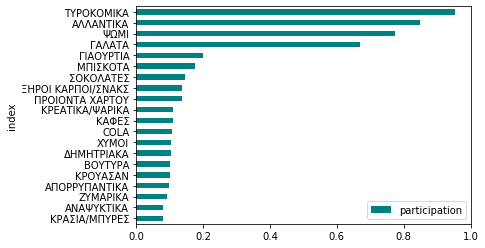

In [73]:
cluster0
c0 = cluster0.sort_values('participation',ascending = True)
ax = c0.plot.barh(x='index', y='participation', rot=0, color = 'teal')

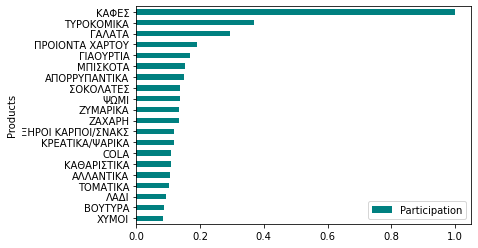

In [76]:
cluster1
c1 = lamp.sort_values('Participation',ascending = True)
ax1 = c1.plot.barh(x='Products', y='Participation', rot=0, color = 'teal')

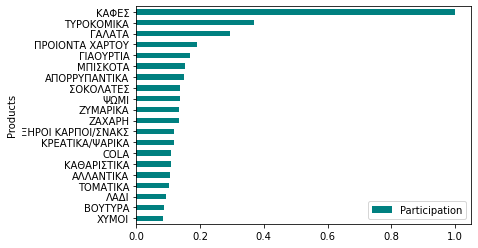

In [75]:
lamp = cluster1.copy()
lamp.rename(columns = {'index':'Products','participation':'Participation'}, inplace = True)

cluster1
c1 = lamp.sort_values('Participation',ascending = True)
ax1 = c1.plot.barh(x='Products', y='Participation', rot=0, color = 'teal')

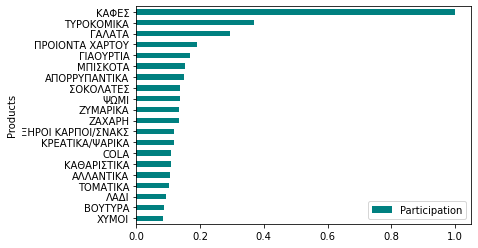

In [77]:
cluster1
c1 = lamp.sort_values('Participation',ascending = True)
ax1 = c1.plot.barh(x='Products', y='Participation', rot=0, color = 'teal')


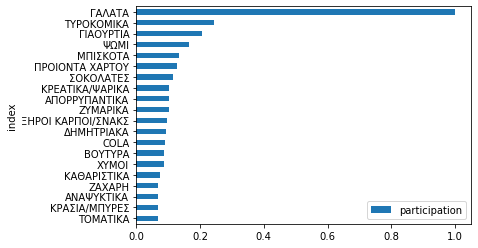

In [78]:
cluster2
c2 = cluster2.sort_values('participation',ascending = True)
ax2 = c2.plot.barh(x='index', y='participation', rot=0)

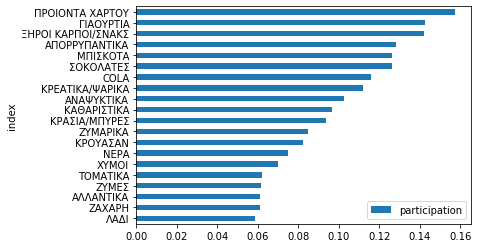

In [79]:
cluster3
c3 = cluster3.sort_values('participation',ascending = True)
ax3 = c3.plot.barh(x='index', y='participation', rot=0)

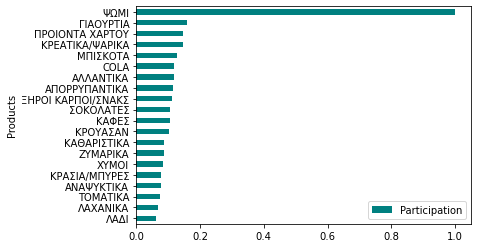

In [80]:
lampr = cluster5.copy()
lampr.rename(columns = {'index':'Products','participation':'Participation'}, inplace = True)
lampr

cluster5
c5 = lampr.sort_values('Participation',ascending = True)
ax5 = c5.plot.barh(x='Products', y='Participation', rot=0, color = 'teal')

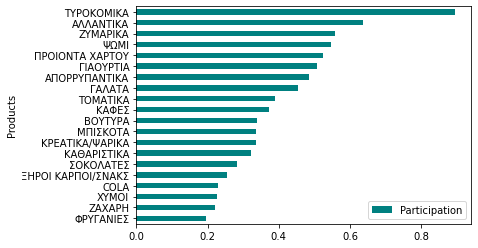

In [81]:
lampr = cluster6.copy()
lampr.rename(columns = {'index':'Products','participation':'Participation'}, inplace = True)
lampr

cluster6
c6 = lampr.sort_values('Participation',ascending = True)
ax5 = c6.plot.barh(x='Products', y='Participation', rot=0, color = 'teal')

In [82]:
st = categories_df0.loc[categories_df0['clusters'] == 0]
sta = st['clusters']
sta = sta.reset_index()
sta.rename(columns = {'index':'Basket_ID'}, inplace = True)


In [83]:
stats = pd.merge(da, sta, on='Basket_ID', how='inner')
stats['Date'] = pd.to_datetime(stats['Date'])

# You can format your date as you wish
stats['Month'] = stats['Date'].dt.month_name(locale='English')
statsm = stats.groupby('Month').count().sort_values('Month',ascending = True)

In [84]:
linex = ['January','February','March','April','May','June','July','August','September','October','November','December']
liney = [676,756,768,739,739,619,642,455,785,866,814,813]


In [85]:
statsd = stats.groupby('day_of_week_name').count().sort_values('Month',ascending = False)

st = categories_df0.loc[categories_df0['clusters'] == 1]
sta = st['clusters']
sta = sta.reset_index()
sta.rename(columns = {'index':'Basket_ID'}, inplace = True)
stats = pd.merge(da, sta, on='Basket_ID', how='inner')
stats['Date'] = pd.to_datetime(stats['Date'])

# You can format your date as you wish
stats['Month'] = stats['Date'].dt.month_name(locale='English')
statsm = stats.groupby('Month').count().sort_values('Grouped',ascending = False)
statsm

,Basket_ID,Grouped,Status,Date,Barcode,Quantity,Value,LoyaltyCard_ID,day_of_week_name,clusters
Month,,,,,,,,,,
March,399,399,399,399,399,399,399,399,399,399
January,389,389,389,389,389,389,389,389,389,389
November,387,387,387,387,387,387,387,387,387,387
February,386,386,386,386,386,386,386,386,386,386
April,381,381,381,381,381,381,381,381,381,381
December,380,380,380,380,380,380,380,380,380,380
October,364,364,364,364,364,364,364,364,364,364
May,323,323,323,323,323,323,323,323,323,323
June,302,302,302,302,302,302,302,302,302,302


In [86]:
statsd = stats.groupby('day_of_week_name').count().sort_values('Month',ascending = False)

st = categories_df0.loc[categories_df0['clusters'] == 5]
sta = st['clusters']
sta = sta.reset_index()
sta.rename(columns = {'index':'Basket_ID'}, inplace = True)
stats = pd.merge(da, sta, on='Basket_ID', how='inner')
stats['Date'] = pd.to_datetime(stats['Date'])

# You can format your date as you wish
stats['Month'] = stats['Date'].dt.month_name(locale='English')
statsm = stats.groupby('Month').count().sort_values('Grouped',ascending = False)

statsd = stats.groupby('day_of_week_name').count().sort_values('Month',ascending = False)

# You can format your date as you wish
da['Month'] = da['Date'].dt.month_name(locale='English')
dam = da.groupby('Month').count().sort_values('Grouped',ascending = False)

dad = da.groupby('day_of_week_name').count().sort_values('Month',ascending = False)
dad

,Basket_ID,Grouped,Status,Date,Barcode,Quantity,Value,LoyaltyCard_ID,Month
day_of_week_name,,,,,,,,,
Saturday,8444,8444,8444,8444,8444,8444,8444,8444,8444
Monday,7732,7732,7732,7732,7732,7732,7732,7732,7732
Friday,7654,7654,7654,7654,7654,7654,7654,7654,7654
Thursday,7076,7076,7076,7076,7076,7076,7076,7076,7076
Tuesday,7074,7074,7074,7074,7074,7074,7074,7074,7074
Wednesday,6819,6819,6819,6819,6819,6819,6819,6819,6819
Sunday,237,237,237,237,237,237,237,237,237


In [87]:
linex = ['January','February','March','April','May','June','July','August','September','October','November','December']
liney = [4413,5107,5239,4789,4554,4080,3809,3041,5162,5660,5200,5213]

In [88]:
dayx = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dayy = [9210,8975,8128,9465,9218,11068,323]

In [89]:
import seaborn as sns

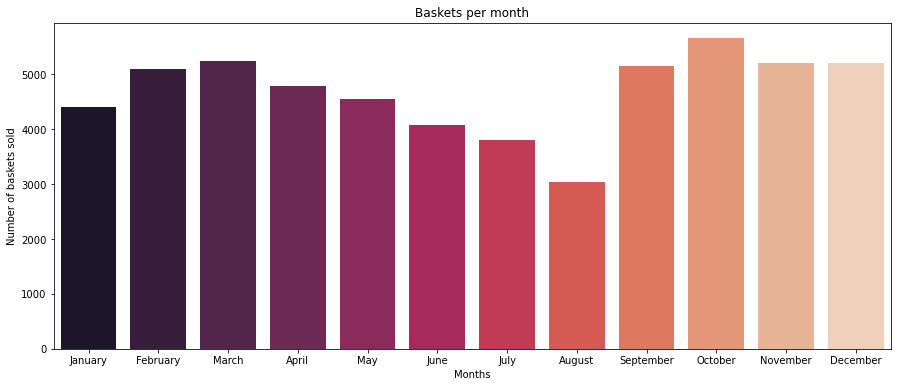

In [90]:
plt.figure(figsize=(15,6))
sns.barplot(x=linex, y=liney, palette="rocket")
plt.title("Baskets per month")
plt.xlabel("Months")
plt.ylabel("Number of baskets sold")
plt.show()

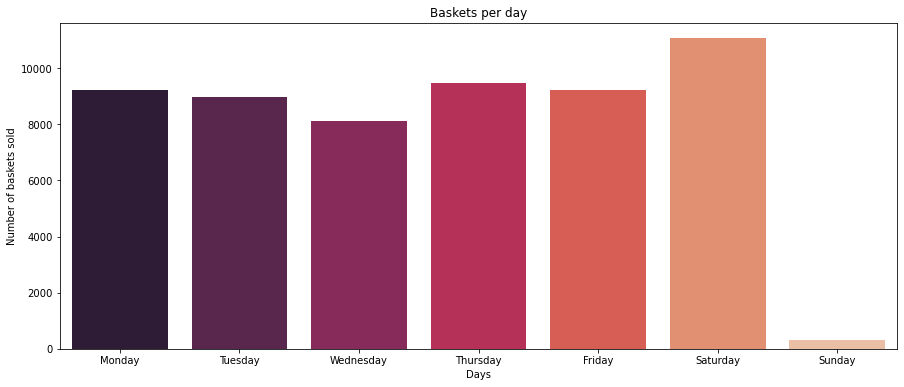

In [91]:
plt.figure(figsize=(15,6))
sns.barplot(x=dayx, y=dayy, palette="rocket")
plt.title("Baskets per day")
plt.xlabel("Days")
plt.ylabel("Number of baskets sold")
plt.show()

In [92]:
ss = da.copy()
statusd = ss.groupby('Status').count().sort_values('Month',ascending = False)
statusd = statusd.drop(['na'])

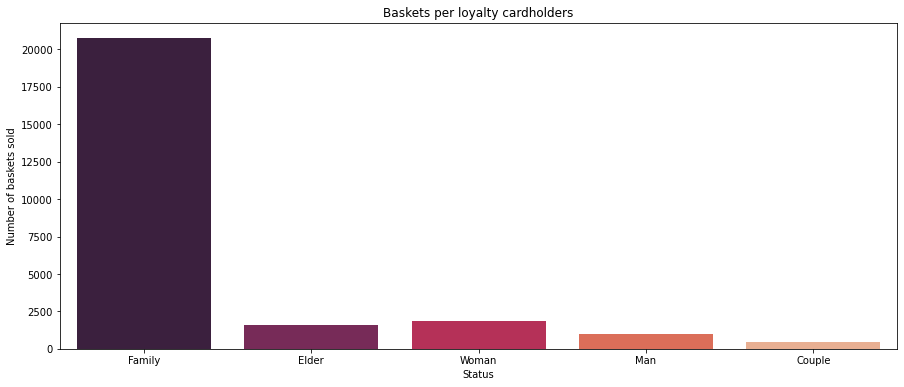

In [93]:
dx = ['Family','Elder','Woman','Man','Couple']
dy = [20752,1606,1874,1010,448]
plt.figure(figsize=(15,6))
sns.barplot(x=dx, y=dy, palette="rocket")
plt.title("Baskets per loyalty cardholders")
plt.xlabel("Status")
plt.ylabel("Number of baskets sold")
plt.show()

In [94]:
all_data.groupby('LoyaltyCard_ID').count().sort_values('Basket_ID',ascending = False)

,Basket_ID,Date,Barcode,Quantity,Value,Status,Category A,Category B,Category C,Category Final
LoyaltyCard_ID,,,,,,,,,,
29338194,1829,1829,1829,1829,1829,1829,1829,1829,1825,1829
29338041,1828,1828,1828,1828,1828,1828,1828,1828,1822,1828
28454097,1553,1553,1553,1553,1553,1553,1553,1553,1553,1553
29338064,1519,1519,1519,1519,1519,1519,1519,1519,1519,1519
28325740,1455,1455,1455,1455,1455,1455,1455,1455,1454,1455
...,...,...,...,...,...,...,...,...,...,...
28592112,2,2,2,2,2,2,2,2,2,2
28909131,2,2,2,2,2,2,2,2,2,2
28368526,2,2,2,2,2,2,2,2,2,2


In [95]:
df_posdata.sort_values('Date',ascending = False)

,Basket_ID,Date,Barcode,Quantity,Value,LoyaltyCard_ID
48329,C29338316B74D20190831,2019-08-31,2240036000000,1,2.35,29338316
21348,C29338017B36D20190831,2019-08-31,5207066107130,1,1.47,29338017
34566,C28367979B55D20190831,2019-08-31,2240244000000,1,5.95,28367979
34565,C28367979B55D20190831,2019-08-31,5201219041203,1,2.92,28367979
34564,C28367979B55D20190831,2019-08-31,5201028094209,1,1.74,28367979
...,...,...,...,...,...,...
157218,C29081487B272D20180901,2018-09-01,5201010101106,1,1.15,29081487
197731,C28416696B376D20180901,2018-09-01,5202575004505,1,1.62,28416696
197730,C28416696B376D20180901,2018-09-01,5201063016013,1,5.86,28416696
197729,C28416696B376D20180901,2018-09-01,5201037703833,1,2.00,28416696


In [96]:
bskcust = o.copy()
bskcust.reset_index()

,LoyaltyCard_ID,clusters
0,117311,4
1,122293,2
2,28002183,66
3,28011966,5
4,28012303,2
...,...,...
2211,29464676,5
2212,29464747,2
2213,29501624,1
2214,29501639,2


In [97]:
bskcust.rename(columns = {'clusters':'Number of Baskets'}, inplace = True)

In [98]:
bskcust.reset_index()

,LoyaltyCard_ID,Number of Baskets
0,117311,4
1,122293,2
2,28002183,66
3,28011966,5
4,28012303,2
...,...,...
2211,29464676,5
2212,29464747,2
2213,29501624,1
2214,29501639,2


In [99]:
sumb = q2.groupby('LoyaltyCard_ID').sum('Quantity')
sumb.reset_index()

,LoyaltyCard_ID,clusters,Barcode,Quantity,Value
0,117311,37,83414128560674,17,45.33
1,122293,95,127874673753657,25,40.53
2,28002183,685,941538954098572,246,611.38
3,28011966,94,134193621549236,30,46.40
4,28012303,28,47785105694686,11,42.73
...,...,...,...,...,...
2211,29464676,36,88212295033528,19,41.64
2212,29464747,10,58745394957560,14,29.90
2213,29501624,9,15621417792507,3,6.05
2214,29501639,53,63253601037495,13,23.31


In [100]:
basketsdata = pd.merge(bskcust,sumb, on='LoyaltyCard_ID', how='inner')


In [101]:
basketsdata.drop(['Barcode','clusters'], axis=1)

,Number of Baskets,Quantity,Value
LoyaltyCard_ID,,,
117311,4,17,45.33
122293,2,25,40.53
28002183,66,246,611.38
28011966,5,30,46.40
28012303,2,11,42.73
...,...,...,...
29464676,5,19,41.64
29464747,2,14,29.90
29501624,1,3,6.05


In [102]:
basketsdata.describe()

,Number of Baskets,clusters,Barcode,Quantity,Value
count,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000
mean,20.323105,372.995487,6.517299e+14,136.355144,268.202559
std,26.963203,574.171403,9.400346e+14,194.842746,384.033384
min,1.000000,0.000000,4.480360e+12,2.000000,0.660000
25%,3.000000,38.000000,7.803451e+13,16.000000,32.550000
50%,10.000000,144.000000,2.672988e+14,56.500000,110.725000
75%,28.000000,453.000000,8.567716e+14,182.000000,353.197500
max,247.000000,6681.000000,9.686977e+15,2078.000000,4779.100000


In [103]:
basketsdata.sort_values('Quantity',ascending = False)

,Number of Baskets,clusters,Barcode,Quantity,Value
LoyaltyCard_ID,,,,,
29338041,175,5798,9686976634198368,2078,4127.71
29338194,121,6681,9503958750033662,1882,4779.10
28454097,158,2041,7451521092578151,1607,2561.31
29338064,213,3292,7611167996314391,1549,2735.92
28325740,247,3132,6969544983760323,1494,2903.07
...,...,...,...,...,...
28592112,1,8,4480360000000,2,7.20
28368352,1,4,10409244153438,2,6.37
28909196,1,8,7457212154006,2,2.46


In [104]:
r = df_posdata.groupby('Basket_ID').sum('Quantity')
r.reset_index()
r = r.drop(['Barcode','LoyaltyCard_ID'], axis=1)

In [105]:
r.reset_index()

,Basket_ID,Quantity,Value
0,C117311B124D20181119,5,13.63
1,C117311B140D20181027,8,23.17
2,C117311B157D20181102,2,6.72
3,C117311B77D20181122,2,1.81
4,C122293B128D20190228,15,21.02
...,...,...,...
45207,C29501639B166D20190613,7,11.54
45208,C29501639B44D20190625,6,11.77
45209,C29501646B249D20190527,8,11.62
45210,C29522019B193D20190729,2,3.22


In [106]:
df_posdata
pos = df_posdata[['Basket_ID','Date','LoyaltyCard_ID']]

In [107]:
pos

,Basket_ID,Date,LoyaltyCard_ID
0,C28002183B2D20181116,2018-11-16,28002183
1,C28002183B2D20181116,2018-11-16,28002183
2,C28002183B2D20181116,2018-11-16,28002183
3,C28002183B2D20181116,2018-11-16,28002183
4,C28002183B2D20181116,2018-11-16,28002183
...,...,...,...
294433,C28368211B826D20181015,2018-10-15,28368211
294434,C28368211B826D20181015,2018-10-15,28368211
294435,C28368211B826D20181015,2018-10-15,28368211
294436,C29081476B841D20181015,2018-10-15,29081476


In [108]:
r = pd.merge(r,pos, on='Basket_ID', how='inner')
r

,Basket_ID,Quantity,Value,Date,LoyaltyCard_ID
0,C117311B124D20181119,5,13.63,2018-11-19,117311
1,C117311B124D20181119,5,13.63,2018-11-19,117311
2,C117311B124D20181119,5,13.63,2018-11-19,117311
3,C117311B124D20181119,5,13.63,2018-11-19,117311
4,C117311B124D20181119,5,13.63,2018-11-19,117311
...,...,...,...,...,...
294433,C29522019B193D20190729,2,3.22,2019-07-29,29522019
294434,C29522019B193D20190729,2,3.22,2019-07-29,29522019
294435,C29522019B313D20190816,3,4.89,2019-08-16,29522019
294436,C29522019B313D20190816,3,4.89,2019-08-16,29522019


In [109]:
r = r.drop_duplicates('Basket_ID')

In [110]:
r

,Basket_ID,Quantity,Value,Date,LoyaltyCard_ID
0,C117311B124D20181119,5,13.63,2018-11-19,117311
5,C117311B140D20181027,8,23.17,2018-10-27,117311
13,C117311B157D20181102,2,6.72,2018-11-02,117311
15,C117311B77D20181122,2,1.81,2018-11-22,117311
17,C122293B128D20190228,15,21.02,2019-02-28,122293
...,...,...,...,...,...
294416,C29501639B166D20190613,7,11.54,2019-06-13,29501639
294423,C29501639B44D20190625,6,11.77,2019-06-25,29501639
294429,C29501646B249D20190527,8,11.62,2019-05-27,29501646
294433,C29522019B193D20190729,2,3.22,2019-07-29,29522019


In [111]:
yvalues = [1,2,3,4,5,6,7,8,9,10,11,12]

In [118]:
xv = re.groupby('LoyaltyCard_ID').count()

In [119]:
xvalues = xv.index
xvalues

Int64Index([  117311,   122293, 28002183, 28011966, 28012303, 28015995,
            28016688, 28016715, 28016796, 28017559,
            ...
            29446265, 29446342, 29446519, 29459575, 29464676, 29464747,
            29501624, 29501639, 29501646, 29522019],
           dtype='int64', name='LoyaltyCard_ID', length=2344)

In [120]:
freq = pd.DataFrame(0, index=xvalues, columns=yvalues)

In [121]:
freq

,1,2,3,4,5,6,7,8,9,10,11,12
LoyaltyCard_ID,,,,,,,,,,,,
117311,0,0,0,0,0,0,0,0,0,0,0,0
122293,0,0,0,0,0,0,0,0,0,0,0,0
28002183,0,0,0,0,0,0,0,0,0,0,0,0
28011966,0,0,0,0,0,0,0,0,0,0,0,0
28012303,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29464747,0,0,0,0,0,0,0,0,0,0,0,0
29501624,0,0,0,0,0,0,0,0,0,0,0,0
29501639,0,0,0,0,0,0,0,0,0,0,0,0


In [122]:
r['Month'] = r['Date'].dt.month 
r

<ipython-input-122-d88a9a44c5c9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r['Month'] = r['Date'].dt.month


,Basket_ID,Quantity,Value,Date,LoyaltyCard_ID,Month
0,C117311B124D20181119,5,13.63,2018-11-19,117311,11
5,C117311B140D20181027,8,23.17,2018-10-27,117311,10
13,C117311B157D20181102,2,6.72,2018-11-02,117311,11
15,C117311B77D20181122,2,1.81,2018-11-22,117311,11
17,C122293B128D20190228,15,21.02,2019-02-28,122293,2
...,...,...,...,...,...,...
294416,C29501639B166D20190613,7,11.54,2019-06-13,29501639,6
294423,C29501639B44D20190625,6,11.77,2019-06-25,29501639,6
294429,C29501646B249D20190527,8,11.62,2019-05-27,29501646,5
294433,C29522019B193D20190729,2,3.22,2019-07-29,29522019,7


In [123]:
re = r.reset_index(drop=True)
re

,Basket_ID,Quantity,Value,Date,LoyaltyCard_ID,Month
0,C117311B124D20181119,5,13.63,2018-11-19,117311,11
1,C117311B140D20181027,8,23.17,2018-10-27,117311,10
2,C117311B157D20181102,2,6.72,2018-11-02,117311,11
3,C117311B77D20181122,2,1.81,2018-11-22,117311,11
4,C122293B128D20190228,15,21.02,2019-02-28,122293,2
...,...,...,...,...,...,...
45207,C29501639B166D20190613,7,11.54,2019-06-13,29501639,6
45208,C29501639B44D20190625,6,11.77,2019-06-25,29501639,6
45209,C29501646B249D20190527,8,11.62,2019-05-27,29501646,5
45210,C29522019B193D20190729,2,3.22,2019-07-29,29522019,7


In [124]:
#ΑΡΧΙΚΟΠΟΙΗΣΗ ΠΙΝΑΚΑ ΓΙΑ ΕΡΩΤΗΜΑ 3
for i in range(len(re)):
    freq.at[(re.loc[i,"LoyaltyCard_ID"]),(re.loc[i,"Month"])] +=1

In [125]:
freq

,1,2,3,4,5,6,7,8,9,10,11,12
LoyaltyCard_ID,,,,,,,,,,,,
117311,0,0,0,0,0,0,0,0,0,1,3,0
122293,0,2,0,0,0,0,0,0,0,0,0,0
28002183,6,8,4,6,8,6,0,0,4,6,8,10
28011966,0,0,0,0,0,0,0,0,4,1,0,0
28012303,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29464747,0,0,0,0,0,0,2,0,0,0,0,0
29501624,0,0,0,0,0,0,0,1,0,0,0,0
29501639,0,0,0,0,0,2,0,0,0,0,0,0
